In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,  format='%(name)s - %(levelname)s - %(message)s')

In [3]:
import os
import argparse
import torch
import json
from collections import defaultdict

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from diffmask.models.question_answering_nq_diffmask import (
    FidQuestionAnsweringNQDiffMask,
)
from diffmask.utils.plot import plot_squad_attributions, print_attributions

/home/tanhexiang/miniconda3/envs/diffmask_fid/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
matplotlib - DEBUG - matplotlib data path: /home/tanhexiang/miniconda3/envs/diffmask_fid/lib/python3.7/site-packages/matplotlib/mpl-data
matplotlib - DEBUG - CONFIGDIR=/home/tanhexiang/.config/matplotlib
matplotlib - DEBUG - interactive is False
matplotlib - DEBUG - platform is linux
matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins'

In [4]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--text_maxlength", type=int, default=200)
    parser.add_argument("--n_context",type=int,default=100)
    parser.add_argument("--gpus", type=str, default="1")
    # parser.add_argument("--model", type=str, default="bert-large-uncased-whole-word-masking-finetuned-squad")
    parser.add_argument(
        "--train_filename",
        type=str,
        default="/data/tanhexiang/tevatron/tevatron/data_nq/result100/fid.nq.dev.jsonl",
    )
    parser.add_argument(
        "--val_filename",
        type=str,
        default="/data/tanhexiang/tevatron/tevatron/data_nq/result100/fid.nq.test.jsonl",
    )
    parser.add_argument(
        "--passages_source_path",
        type=str,
        default="/data/tanhexiang/CF_QA/data/wikipedia_split/psgs_w100.tsv"
    )
    parser.add_argument("--batch_size", type=int, default=1)
    parser.add_argument("--gate_bias", action="store_true")
    parser.add_argument("--seed", type=float, default=0)
    parser.add_argument(
        "--model_path",
        type=str,
        default="/data/tanhexiang/CF_QA/models/reader/nq_reader_base",
    )

    # 关于gate的参数
    parser.add_argument("--learning_rate_alpha", type=float, default=3e-1)
    parser.add_argument("--learning_rate_placeholder", type=float, default=1e-3)
    parser.add_argument("--eps", type=float, default=1)
    parser.add_argument("--eps_valid", type=float, default=3)
    parser.add_argument("--acc_valid", type=float, default=0.0)
    parser.add_argument("--placeholder", action="store_true")
    parser.add_argument("--stop_train", action="store_true")
    parser.add_argument(
        "--gate",
        type=str,
        default="input",
        choices=["input", "hidden", "per_sample-reinforce", "per_sample-diffmask"],
    )
    parser.add_argument("--layer_pred", type=int, default=-1)

    hparams, _ = parser.parse_known_args()
    
    torch.manual_seed(hparams.seed)
    
    os.environ["CUDA_VISIBLE_DEVICES"] = hparams.gpus

# Loading a model

In [5]:
device = "cuda:0"
model = FidQuestionAnsweringNQDiffMask(hparams=hparams).to(device)
model.freeze()

urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /home/tanhexiang/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
transformers.configuration_utils - INFO - loading configuration file /data/tanhexiang/CF_QA/models/reader/nq_reader_base/config.json
transformers.configuration_utils - INFO - Model config T5Config {
  "architectures": [
    "FiDT5"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attentio

requires_grad: alpha.0
requires_grad: alpha.1
requires_grad: alpha.2
requires_grad: alpha.3
requires_grad: alpha.4
requires_grad: alpha.5
requires_grad: alpha.6
requires_grad: alpha.7
requires_grad: alpha.8
requires_grad: alpha.9
requires_grad: alpha.10
requires_grad: alpha.11
requires_grad: alpha.12
requires_grad: alpha.13
requires_grad: gate.g_hat.0.bias
requires_grad: gate.g_hat.0.f.0.bias
requires_grad: gate.g_hat.0.f.0.weight_g
requires_grad: gate.g_hat.0.f.0.weight_v
requires_grad: gate.g_hat.0.f.2.weight_g
requires_grad: gate.g_hat.0.f.2.weight_v
requires_grad: gate.g_hat.1.bias
requires_grad: gate.g_hat.1.f.0.bias
requires_grad: gate.g_hat.1.f.0.weight_g
requires_grad: gate.g_hat.1.f.0.weight_v
requires_grad: gate.g_hat.1.f.2.weight_g
requires_grad: gate.g_hat.1.f.2.weight_v
requires_grad: gate.g_hat.2.bias
requires_grad: gate.g_hat.2.f.0.bias
requires_grad: gate.g_hat.2.f.0.weight_g
requires_grad: gate.g_hat.2.f.0.weight_v
requires_grad: gate.g_hat.2.f.2.weight_g
requires_grad

# Creating and plotting DiffMask attributions

In [6]:
# 创建数据库，例子
from diffmask.models.question_answering_nq import (
    load_nq, Dataset, Collator
)
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base', return_dict=False)
collator = Collator(hparams.text_maxlength, tokenizer)
data = load_nq(hparams.val_filename)
dataset = Dataset(data, n_context=100, passages_source_path=hparams.passages_source_path)
dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=collator
        )

urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /home/tanhexiang/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
asyncio - INFO - Loaded 3610 records from /data/tanhexiang/tevatron/tevatron/data_nq/result100/fid.nq.test.jsonl
root - INFO - successfully load data, len 3610


In [7]:
batch = next(iter(dataloader))
(index, target_ids, target_mask, passage_ids, passage_mask) = batch
passage_ids.shape

torch.Size([1, 100, 200])

In [12]:
logits_orig, expected_L0_full = model.forward_explainer(
    (index.to(device), target_ids.to(device), target_mask.to(device), passage_ids.to(device), passage_mask.to(device)), attribution=True
)                                                                                                  
attributions = expected_L0_full.exp().cpu()

root - DEBUG - passage_ids torch.Size([1, 100, 200]), passage_masks torch.Size([1, 100, 200])


gates.py: hidden_states[0] shape torch.Size([100, 200, 768])


AttributeError: 'tuple' object has no attribute 'shape'

: 

In [ ]:
attributions[:,25]


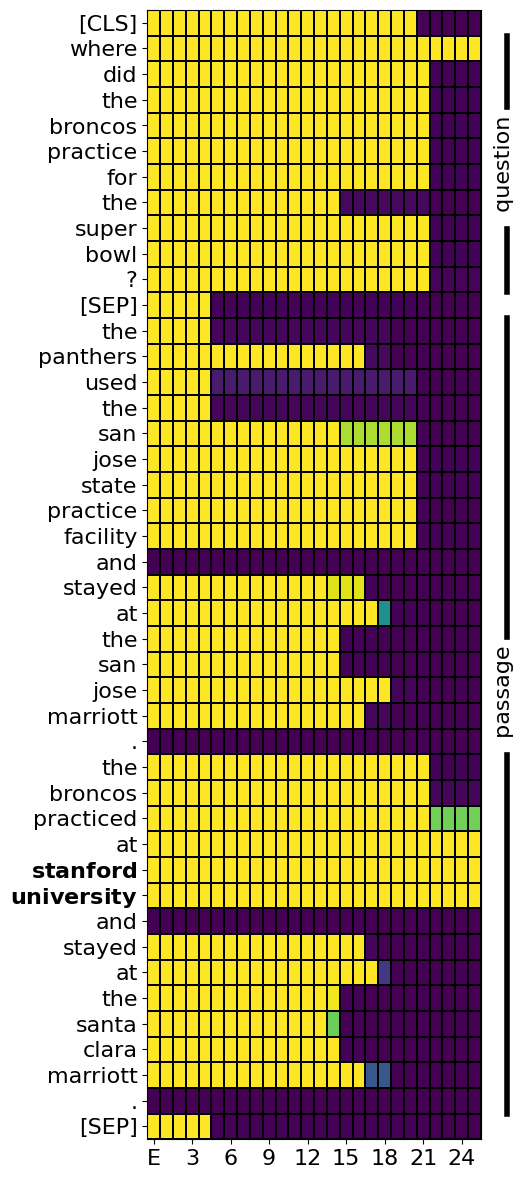

In [ ]:
plot_squad_attributions(attributions, tokens, context, question, inputs_dict, logits_start_orig, logits_end_orig)

In [ ]:
print_attributions(tokens, attributions.sum(-1))

[CLS] where did the broncos practice for the super bowl ? [SEP] the panthers used the san jose state practice facility and stayed at the san jose marriott . the broncos practiced at stanford university and stayed at the santa clara marriott . [SEP]


# Computing statistics on the validation set

In [ ]:
with open(
    "./datasets/squad/dev-v1.1_bert-large-uncased-whole-word-masking-finetuned-squad-mapping.json", "r"
) as f:
    model.val_dataset_orig_offsets = json.load(f)
    
model.prepare_data()

In [ ]:
val_dataset_orig = [e for e in model.val_dataset_orig.items()]
for i, batch in tqdm(enumerate(model.val_dataloader()), total=len(model.val_dataset) // model.hparams.batch_size):
    input_ids, mask, token_type_ids, _, _ = tuple(e.to(device) for e in batch)

    logits_start, logits_end, expected_L0_full = model.forward_explainer(
        input_ids, mask, token_type_ids, attribution=True
    )
    attributions = expected_L0_full.exp().cpu()

    for j in range(attributions.shape[0]):
        question_offset = len(val_dataset_orig[i * model.hparams.batch_size + j][1]["question"])
        val_dataset_orig[i * model.hparams.batch_size + j][1]["question"] = (
            val_dataset_orig[i * model.hparams.batch_size + j][1]["question"],
            attributions[j, 1:1 + question_offset]
        )

        val_dataset_orig[i * model.hparams.batch_size + j][1]["context"] = (
            val_dataset_orig[i * model.hparams.batch_size + j][1]["context"],
            attributions[j, 2 + question_offset:mask[j].sum().item() - 1]
        )
        
        val_dataset_orig[i * model.hparams.batch_size + j][1]["answer_model"] = [
            logits_start[j].argmax(-1).item() - question_offset - 2,
            logits_end[j].argmax(-1).item() - question_offset - 2,
        ]
        val_dataset_orig[i * model.hparams.batch_size + j][1]["special"] = attributions[
            j, [0, 1 + question_offset, mask[j].sum().item() - 1]
        ]
        
val_dataset_orig = dict(val_dataset_orig)

In [ ]:
question_use = torch.stack([v["question"][1].mean(0) for k, v in val_dataset_orig.items()]).mean(0)
context_use = torch.stack([v["context"][1].mean(0) for k, v in val_dataset_orig.items()]).mean(0)
answer_model_use = torch.stack([
    (v["context"][1][v["answer_model"][0]] + v["context"][1][v["answer_model"][1]]) / 2
    for k, v in val_dataset_orig.items()
]).mean(0)

answer_correct_use = [[(v["context"][1][s] + v["context"][1][e]) / 2
               for s, e in v["answer_offsets"]]
              for k, v in val_dataset_orig.items()]
answer_correct_use = torch.stack([torch.stack(e).max(0).values for e in answer_correct_use]).mean(0)

answer_wrong_use = [[(v["context"][1][s] + v["context"][1][e]) / 2
               for s, e in v["answer_offsets"]]
              for k, v in val_dataset_orig.items() if v["answer_model"] not in v["answer_offsets"]]
answer_wrong_use = torch.stack([torch.stack(e).max(0).values for e in answer_wrong_use]).mean(0)

fig = plt.figure(figsize=(6, 6))

plt.plot(question_use, marker="o", linewidth=2, label="Question")
plt.plot(context_use, marker="^", linewidth=2, label="Passage")
plt.plot(answer_correct_use, marker="X", linewidth=2, label="Ground truth")
plt.plot(answer_wrong_use, marker="s", linewidth=2, label="G.t. w/ wrong prediciton")

plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=20)
plt.yticks(torch.linspace(0, 1, 6), ["{:.1f}".format(e) for e in torch.linspace(0, 1, 6)], size=20)

plt.ylim(-0.1, 1.1)
plt.legend(fontsize=16, loc="lower left") #, frameon=False)
plt.show()

In [ ]:
counts = {
    k: defaultdict(list) for k in ("question", "context", "all")
}
for k, v in tqdm(model.val_dataset_orig_offsets.items()):
    if k in val_dataset_orig:
        e = val_dataset_orig[k]
        for g in ("question", "context"):
            for f, s in zip([f[2] for f in v[g]], e[g][-1].sum(-1)):
                counts[g][f].append(s)
                counts["all"][f].append(s)
        counts["all"]["[CLS]"].append(e["special"][0].sum(-1))
        counts["all"]["[SEP] 1"].append(e["special"][1].sum(-1))
        counts["all"]["[SEP] 2"].append(e["special"][2].sum(-1))
                
for g in ("question", "context", "all"):
    print(g)
    
    counts[g] = sorted([(k, torch.stack(v)) for k, v in counts[g].items()])
    counts[g] = [(k, (v.mean(), v.std())) for k, v in counts[g]]
    counts[g] = sorted(counts[g], key=lambda x: x[1][0])

    fig = plt.figure(figsize=(4, len(counts[g]) / 2))
    plt.barh(range(len(counts[g])),
            [m.item() for k, (m, s) in counts[g]],
            xerr=[s.item() for k, (m, s) in counts[g]],
            capsize=3)
    plt.yticks(torch.arange(len(counts[g])), [k for k, (m, s) in counts[g]], size=16)
    plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=16)
    
    plt.xlim(-4, 32)
    plt.margins(y=.5 / len(counts[g]))

    plt.show()

In [ ]:
counts = {
    k: defaultdict(list) for k in ("question", "context")
}
for k, v in tqdm(model.val_dataset_orig_offsets.items()):
    if k in val_dataset_orig:
        e = val_dataset_orig[k]
        for g in ("question", "context"):
            for f, s in zip([f[-1] if len(f) == 7 else "OTHER" for f in v[g]], e[g][-1].sum(-1)):
                counts[g][f].append(s)
                
for g in ("question", "context"):
    print(g)
    
    counts[g] = sorted([(k, torch.stack(v)) for k, v in counts[g].items()])
    counts[g] = [(k, (v.mean(), v.std())) for k, v in counts[g]]
    counts[g] = sorted(counts[g], key=lambda x: x[1][0])
    
    fig = plt.figure(figsize=(4, len(counts[g]) / 2))
    plt.barh(range(len(counts[g])),
            [m.item() for k, (m, s) in counts[g]],
            xerr=[s.item() for k, (m, s) in counts[g]],
            capsize=3)
    plt.yticks(torch.arange(len(counts[g])), [k for k, (m, s) in counts[g]], size=16)
    plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=16)
    
    plt.xlim(-4, 32)
    plt.margins(y=.5 / len(counts[g]))

    plt.show()